# Movie Recommendation - Mission 1

### Movielense Dataset EDA


EDA(Exploratory Data Analysis)는 데이터셋을 다양한 각도에서 관찰하고 인사이트를 얻을 수 있는 중요한 데이터 분석 과정입니다. 이를 잘 수행하여 데이터의 특징과 분포에 대해 깊은 이해도를 가진다면, 모델의 성능에도 큰 영향을 끼칠 수 있습니다.

본 미션에서는 Movie Recommendation 대회를 위해 제공되는 [movielens](https://grouplens.org/datasets/movielens/) 를 재구성한 대회 데이터셋에 대한 EDA를 진행하고, 학습 데이터에 더불어 영화의 side-information 데이터에 대해 이해하는 시간을 가져보겠습니다!

## 대회 데이터셋 구성
먼저 데이터셋의 구성을 살펴봅니다.

### data
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv
    
1. *train_ratings.csv* : 전체 훈련 데이터.
2. *directors.tsv*, *genres.tsv*, *writers.tsv*, *years.tsv*, *titles.tsv* : 영화의 side-information 데이터.

## train/test 데이터셋 알아보기

Pandas를 이용하여 train 데이터를 로드하고 데이터 구성을 알아봅니다. 이어지는 코드를 실행하면 데이터셋의 간략한 정보와 샘플을 확인할 수 있습니다.

train 데이터셋은 *user, item, time* 세개의 column으로 구성된 반면, test 데이터셋은 *user* column과 비어있는 *item* column으로 구성되어 있음을 참고해 주세요. 대회 진행시, 각각의 사용자에게 10개의 영화를 추천하게 됩니다.

각 column은 다음을 나타냅니다.
- *user*: 사용자 id.
- *item*: 영화 id.
- *time*: 사용자가 해당 영화와 interact한 시간. (UNIX시간의 초 단위)

영화 id는 *directors.tsv, genres.tsv, writers.tsv, years.tsv, titles.tsv*에서도 일관적으로 사용됩니다. 즉, 동일한 영화 id는 side information 데이터셋에서 동일한 영화를 나타냅니다.

이어지는 cell들을 실행해서 직접 관찰해보세요!

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
data_path = '../../data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [4]:
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [5]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)

Number of unique train users:  31360
Number of unique train items:  6807


In [6]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


데이터의 sparsity ratio는 약 97.6%로 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있습니다.

## Side Information 알아보기

다음은 side information 데이터를 알아봅니다. 일반적으로 추천시스템에서는 side information을 더욱 잘 활용할수록 더 좋은 추천 결과를 얻을 수 있게 됩니다.

주어진 year, writer, title, genre, director 데이터를 불러옵니다. 마찬가지로 각 데이터의 간략한 정보를 확인하고 샘플을 미리 저장해보겠습니다. 샘플된 데이터는 뒤에서도 계속 사용할 예정인 점을 참고해주세요! 그럼 다음 코드를 실행해보겠습니다.

In [7]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

그러면 먼저 *years.tsv* 데이터를 알아보겠습니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *year* : 해당 영화가 개봉한 연도.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

그리고 바로 이어지는 cell을 실행하여 추가적인 통계도 확인합니다. 데이터셋에 한 번 이상 출현하는 영화 작품은 총 6799편이며 평균 개봉 연도는 1992년인 등의 정보를 파악할 수 있습니다.

In [8]:
year_data.info()
year_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923


In [9]:
print ("Year data shape: ", year_data.shape)
print("Number of unique items in year_df: ", year_data['item'].nunique())
print("Number of unique years: ", year_data['year'].nunique())
print ("\nStatistics of year data: ")
year_data['year'].describe()

Year data shape:  (6799, 2)
Number of unique items in year_df:  6799
Number of unique years:  93

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

**총 6807개의 영화 중 6799개의 영화만 year 정보가 존재 (8개의 영화는 year 정보 없음)**

다음은 *writers.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *writer* : 영화의 각본가. (익명화)

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [10]:
writer_data.info()
writer_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
0,1237,nm0000005
1,5147,nm0000005


In [11]:
writer_data.groupby(writer_data['item']).size()

item
1         7
2         3
3         1
4         1
5         4
         ..
118696    5
118900    1
118997    1
119141    2
119145    4
Length: 5648, dtype: int64

In [12]:
writer_data.groupby(writer_data['item']).size().max()

24

In [13]:
writer_data.groupby(writer_data['item']).size().mean()

2.001770538243626

평균 하나의 영화 당 2명의 writer 정보가 존재  
최대 24명의 writer 정보가 존재함

In [14]:
writer_data['item'].unique().shape

(5648,)

총 5648개의 영화에 대해서만 writer 정보 존재  
**즉, 1159편의 영화에 대해서는 writer 정보 없음**

In [28]:
writer_data.groupby(writer_data['writer']).size().max()

47

In [29]:
writer_data.groupby(writer_data['writer']).size().mean()

3.7825359652057546

<AxesSubplot:xlabel='item', ylabel='count'>

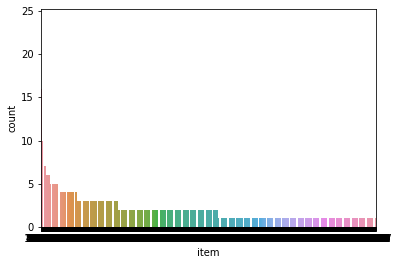

In [15]:
sns.countplot(x='item', data=writer_data, order = writer_data['item'].value_counts().index)

<AxesSubplot:xlabel='writer', ylabel='count'>

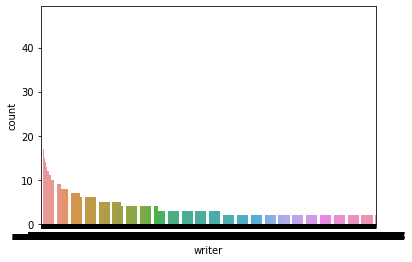

In [16]:
sns.countplot(x='writer', data=writer_data, order = writer_data['writer'].value_counts().index)

In [27]:
writer_data['writer'].unique().shape

(2989,)

다음은 *titles.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *titles* : 영화 제목.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [17]:
title_data.info()
title_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)
3,296,Pulp Fiction (1994)
4,356,Forrest Gump (1994)


다음은 *genres.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *genre* : 영화의 장르.

하나의 영화는 여러 개의 장르를 가질 수 있습니다.
다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [18]:
genre_data.info()
genre_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


In [19]:
genre_data['item'].unique().shape

(6807,)

In [20]:
genre_data['genre'].unique().shape

(18,)

In [21]:
genre_data.groupby(genre_data['item']).size()

item
1         5
2         3
3         2
4         3
5         1
         ..
118700    1
118900    1
118997    4
119141    2
119145    4
Length: 6807, dtype: int64

In [22]:
genre_data.groupby(genre_data['item']).size().max()

10

In [23]:
genre_data.groupby(genre_data['item']).size().mean()

2.3406787130894666

In [24]:
genre_data.groupby(genre_data['item']).size()

item
1         5
2         3
3         2
4         3
5         1
         ..
118700    1
118900    1
118997    4
119141    2
119145    4
Length: 6807, dtype: int64

<AxesSubplot:xlabel='item', ylabel='count'>

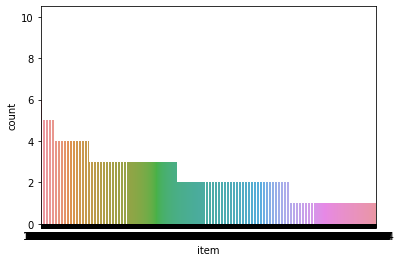

In [25]:
sns.countplot(x='item', data=genre_data, order = genre_data['item'].value_counts().index)

<AxesSubplot:xlabel='genre', ylabel='count'>

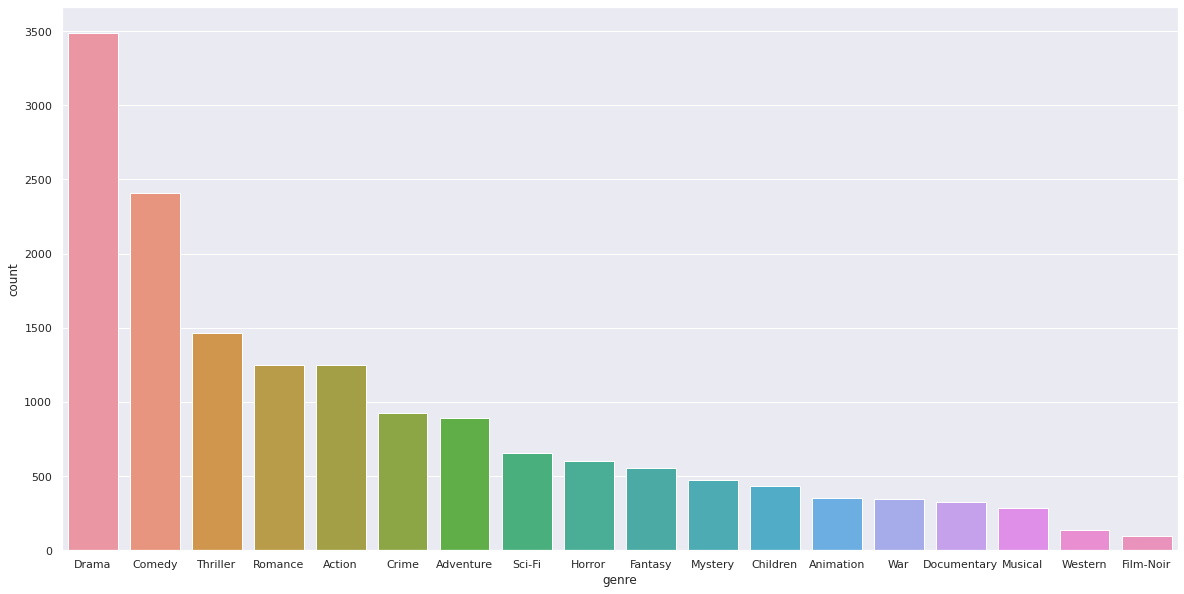

In [34]:
sns.set(rc={'figure.figsize':(20,10)})
sns.countplot(x='genre', data=genre_data, order = genre_data['genre'].value_counts().index)

마지막으로 *directors.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *director* : 영화 감독. (익명화)

하나의 영화는 여러 명의 감독을 가질 수 있습니다. 다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [35]:
director_data.info()
director_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005


In [48]:
director_data['director'].unique().shape

(1340,)

In [49]:
director_data['item'].unique().shape

(5503,)

In [50]:
director_data.groupby(director_data['item']).size().max()

14

In [51]:
director_data.groupby(director_data['item']).size().mean()

1.0730510630565147

In [53]:
director_data.groupby(director_data['director']).size().max()

44

In [54]:
director_data.groupby(director_data['director']).size().mean()

4.406716417910448

## 데이터 시각화 해보기
앞에서 주어진 데이터셋을 먼저 간단히 살펴보았습니다. 이제부터는 다수의 파일을 merge하여 시각화하고, 데이터에 대해 좀 더 깊은 이해를 해보겠습니다.

먼저 효율적인 데이터 시각화를 위해, 데이터셋에서 빈도수가 높은 movie, user 데이터의 id를 미리 저장하겠습니다.
train 데이터에서 데이터의 출현 빈도 순으로 *active_user_ids*와 *popular_movie_ids*에 top 10을 각각 저장합니다.

대회 데이터셋에서 빈도수가 높을수록 유명한 영화를 나타내는 것은 아니지만, 편의상 *popular_movie_id* 변수명을 사용하는 점을 당부드립니다.

다음 코드를 실행해주세요.

In [36]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Int64Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122,
            118754],
           dtype='int64', name='user')

popular movie ids:  Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


*active_user_ids*와 *popular_movie_ids*에 각각 빈도가 높은 영화와 사용자 id들을 저장했습니다. 뒤에서도 계속 사용할 예정이니 참고해 주세요.

이제부터는 train 데이터와 side information 데이터를 merge하고, side information 별 user-item 빈도수가 높은 데이터 샘플을 미리 저장합니다. 위에서 저장한 active user id와 popular movie id와 다르게 여기서는 바로 Pandas Dataframe의 형태로 샘플을 저장합니다. 빈도가 가장 높은 10개 side information data가 해당하는 모든 user-item interaction를 저장할 것이므로, 각 side information 데이터 샘플의 크기는 상이합니다.

이어지는 코드 cell들을 실행해보고, 출력된 결과를 충분히 관찰해보시기 바랍니다.

In [37]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10] # top 10 director id

side_df = []
for director in director_id:`
    side_df.append(director_df.loc[director_df['director'] == director])

director_top = pd.concat(side_df)

print ("Number of all unique director ids: ", director_df['director'].nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

Number of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
            user   item        time   director
943691    49667    296  1339487006  nm0000233
3498420   37888     16  1141539602  nm0000217
188540   115626   1270  1172433448  nm0000709
3502869   17085   5989  1310235676  nm0000229
2004178   69124  55820  1280778117  nm0001054

shape of the data:  (672019, 4)


In [75]:
writer_df

,user,item,time,writer
0,11,4643,1230782529,nm0099541
1,11,4643,1230782529,nm0115310
2,11,4643,1230782529,nm0465199
3,11,4643,1230782529,nm0742797
4,189,4643,1302945016,nm0099541
...,...,...,...,...
11278910,130972,102880,1391096866,nm1729428
11278911,131347,102880,1370143675,nm0796117
11278912,131347,102880,1370143675,nm1729428
11278913,134144,102880,1371381972,nm0796117


In [38]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

side_df = []
for writer in writer_id:
    side_df.append(writer_df.loc[writer_df['writer'] == writer])

writer_top = pd.concat(side_df)

print ("Number of all unique writer ids: ", writer_df['writer'].nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

Number of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
            user   item        time     writer
1703650   46403   6539  1164116489  nm0744429
3265841  112244  58559  1415751998  nm0634240
1666738   47249   6874  1229039509  nm0000233
1427977   25379   4993  1354539524  nm0909638
3706877   91185   7153  1415408844  nm0909638

shape of the data:  (651286, 4)


In [76]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]


side_df = []
for title in title_id:
    side_df.append(title_df.loc[title_df['title'] == title])

title_top = pd.concat(side_df)

print ("Number of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

Number of all unique movie titles:  6806

top 10 movie titles: 
 Index(['Matrix, The (1999)', 'Fight Club (1999)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Silence of the Lambs, The (1991)', 'American Beauty (1999)'],
      dtype='object', name='title')

sample of top 10 user-title data: 
            user  item        time  \
846720   112112   296  1295142736   
818280   130190  2959  1294546794   
1079339   77366  5952  1225270408   
591187    59738  4993  1389860471   
1082537  103731  5952  1313846481   

                                                     title  
846720                                 Pulp Fiction (1994)  
818280                                   Fight Club (1999)  
1079339      Lord of the Rings: The Two Towers, The (2002) 

In [80]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

side_df = []
for year in year_id:
    side_df.append(year_df.loc[year_df['year'] == year])

year_top = pd.concat(side_df)

print ("All unique years: \n", np.sort(year_df['year'].unique())) 
print ("\nNumber of all unique years: ", year_df['year'].nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 [1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014]

Number of all unique years:  93

top 10 years: 
 Int64Index([2004, 1999, 2001, 2002, 2006, 2003, 2000, 2005, 1995, 2007], dtype='int64', name='year')

sample of top 10 user-year data: 
            user   item        time  year
1607444   51259   8529  1227298943  2004
4795920   12363  54745  1218946619  2007
2260785   87856  44665  1164924258  2006
1604082  112680   4027  1173384001  2000
3795723  126338   5954  1252731889  2002

shape of the data:  (2173226, 4)


여기까지 director, writer, title, year 데이터를 확인해 보았는데요. 이어서 genre 데이터도 관찰해보겠습니다. 데이터셋에서 genre의 수가 총 18개밖에 없으므로 빈도수가 높은 genre를 따로 저장할 필요 없이, train 데이터와의 merge를 바로 진행하겠습니다.

다음 코드를 실행하고 genre 데이터의 형태도 관찰해보세요.

In [41]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_top = genre_df

print ("All unique genres: \n", np.sort(genre_df['genre'].unique())) 
print ("\nNumber of all unique genres: ", genre_df['genre'].nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Number of all unique genres:  18

sample of user-genre data: 
             user   item        time      genre
13035518   74193   3070  1283526511     Comedy
4862836       14  26294  1225311909    Western
11406173   75898    788  1324771645    Romance
11703053  100999   3629  1239508196    Romance
2302080    57516  54001  1291253620  Adventure

shape of the data:  (14126324, 4)


여기까지 오셨으면 side information 데이터의 형태를 충분히 파악하셨을 것으로 생각됩니다! 이제
matplotlib library를 사용하여 샘플한 데이터를 그래프로 시각화해봅니다. 

In [42]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

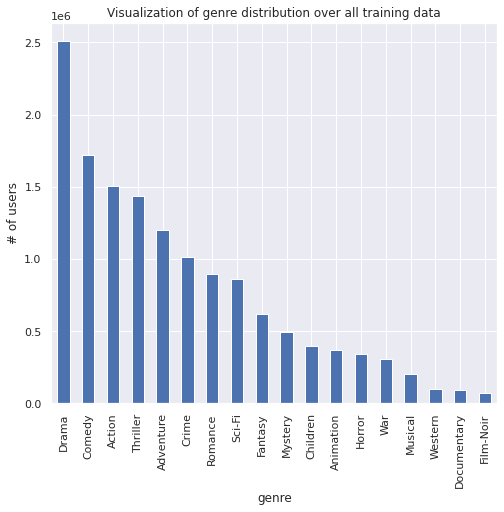

In [43]:
genre_top['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')
plt.show

데이터셋에서 가장 많이 출현하는 장르가 *Drama*, 가장 적게 출현하는 장르가 *Film-Noir*임을 확인할 수 있었습니다.

그러면 전체 training 데이터에서의 genre 분포 뿐만 아니라, genre 데이터 단독의 분포를 출력하면 어떤지 비교해 봅니다. 코드를 실행해주세요.

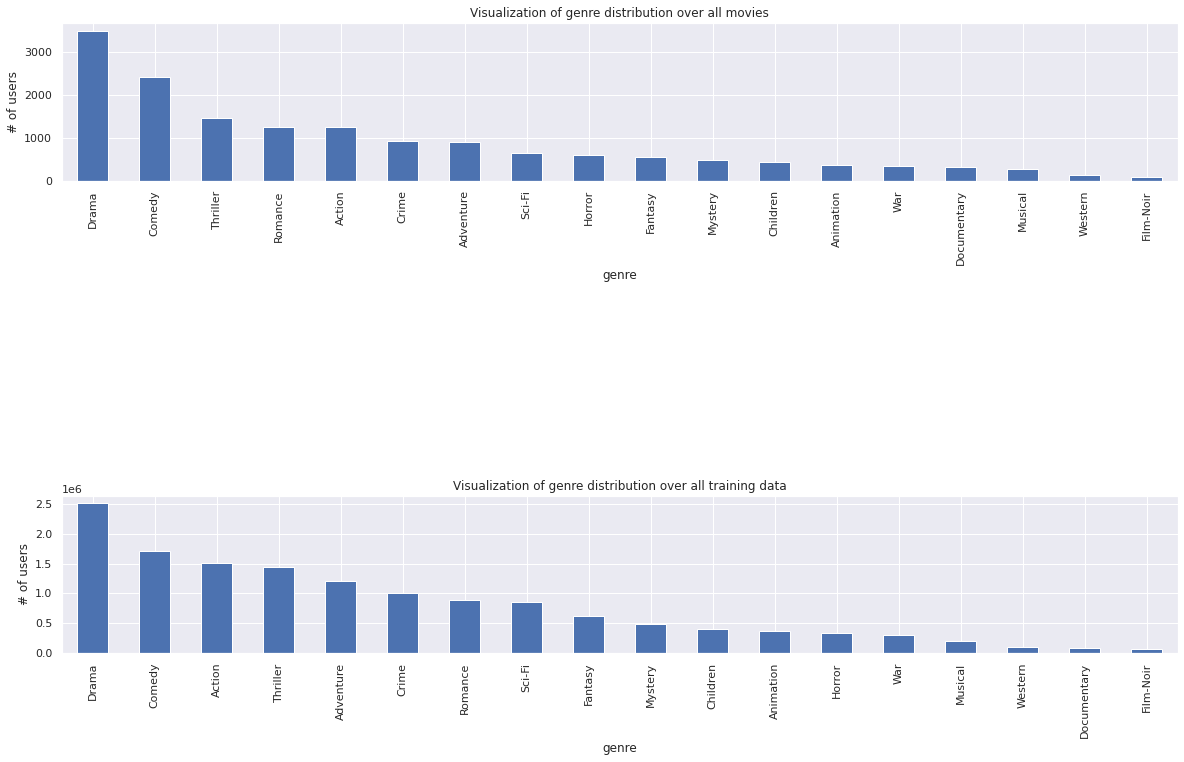

In [44]:
plt.subplot(2,1,1)
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all movies')

plt.subplot(2,1,2)
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

plt.subplots_adjust(hspace=2.0, top=1.0)

두 개의 그래프를 확인하면 거의 비슷해보이지만, 두 분포 사이에 작은 차이가 있음을 확인할 수 있습니다. 가령, *Romance* 장르의 영화가 전체 훈련 데이터에서는 7위를 차지하지만, 모든 6807개의 영화 중에서는 4위를 차지합니다. 이는 *Romance* 장르에 해당하는 영화의 갯수에 비해 실제 사용자들이 시청할 확률이 더 높았다는 것을 뜻합니다.

다음은 사용자 한명이 시청한 영화 리스트를 확인하고, 해당 사용자가 가장 선호하는 장르를 순위별로 차트로 알아보겠습니다. 다음 코드에서는 데이터가 가장 많은 사용자의 id인 `active_user_ids[0]`를 사용하겠습니다.
그럼 코드를 실행해보세요!

<AxesSubplot:>

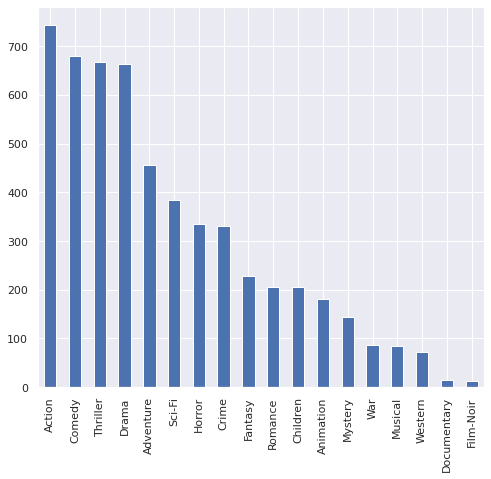

In [96]:
user_id = active_user_ids[1] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

`active_user_ids[0]`에 해당하는 사용자의 시청영화 장르 분포는 전체 데이터의 장르 분포와 크게 차이가 나지 않습니다. 그렇다면 `active_user_ids[1]`에 해당하는 사용자는 어떨까요? 다양한 사용자들의 장르 분포도 한번 비교해 보시기 바랍니다.


다음은 사용자가 주로 언제 영화를 시청했는지 알아보려고 합니다.
그 전에 먼저 간단히 알고 넘어가면 좋은 내용이 있는데요. train 데이터를 보시면 timestamp column은 유닉스 시간(Unix time)을 초 단위로 표시한 것입니다. 통계를 위해 이것을 우리가 알아볼 수 있는 단위로 변환하는 방법을 알아보겠습니다. 다음 코드를 실행해보세요.

In [46]:
import time
unix_time = 1230782529 # some random timestamp from dataset
converted_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(unix_time))

print ("initial unix-based timestamp: %s\nconverted time: %s"%(unix_time, converted_time))

initial unix-based timestamp: 1230782529
converted time: 2009-01-01 04:02:09


파이썬의 time 라이브러리를 사용하여 연-월-일 시간-분-초 단위까지 잘 변환이 되는 것을 확인했습니다. 
하지만 우리 데이터셋의 영화 연도 분포와 task를 고려했을때 시간-분-초 단위는 크게 중요하지 않을 것 같습니다. 일 단위도 빼고, 연-월 단위만 가지고 사용자의 시청 연-월 그래프를 확인해보겠습니다.

즉, 위와 같은 방법으로 timestamp를 변환하여 `active_user_ids[0]`에 해당하는 사용자가 어느 시기에 가장 많은 interaction 활동을 했는지 알아봅니다. 다음 코드를 실행하여 그래프를 확인해봅니다.

/tmp/ipykernel_8926/3498642440.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column


Text(0.5, 1.0, 'Statistics of user activity')

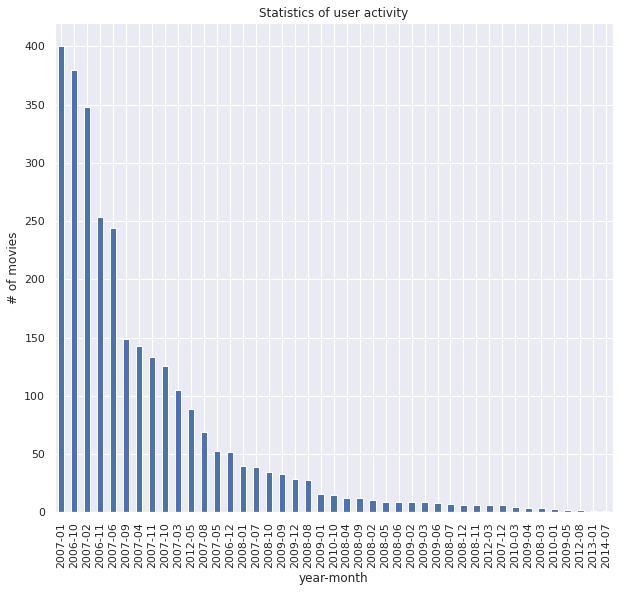

In [97]:
old_df = train_df[train_df['user'] == active_user_ids[0]] # Specific user id
converted_df = old_df

for old_time in old_df['time']:
    new_time = time.strftime('%Y-%m', time.localtime(old_time))
    converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column

converted_df['time'].value_counts().plot(kind = 'bar', figsize = (10,9))
plt.xlabel('year-month')
plt.ylabel('# of movies')
plt.title('Statistics of user activity')

해당 사용자는 대략 2007년 전후로 영화 시청을 가장 많이 했고, 시간이 지나면서 시청 기록이 점점 줄어드는 확인할 수 있습니다.

이어서 사용자가 처음으로 또는 마지막으로 영화 시청을 한 시기도 직접 출력해볼 수 있겠습니다. 또, 다른 사용자들의 분포는 얼마나 다를까요?
혹은, 어떤 영화가 어떤 연도에 가장 많이 소비되었을까요?

눈치 채셨을지 모르겠지만, 앞서 저장했던 *popular_movie_id* 변수는 시각화에 사용되지 않았는데요. 선택 과제로 활용해보시기 바랍니다!

## 마치며

여기까지 오시느라 모두 수고 많으셨습니다. 본 미션에서는 여러 데이터를 관찰하고, 또 분포를 출력해보면서 데이터에 대해 이해하는 시간을 가져보았는데요.
미션에서 제공된 정보 외에도 다른 분석들을 추가로 해보시면 대회를 준비하는데 더 도움이 될 것입니다.
많은 인사이트를 얻어가셔서 대회에 충분히 활용하시길 바라겠습니다!